# Reproduce the cuts on generator level

The bhabha (`2f_z_eehiq`) sample would have been unmanagably large with the standard ILD production cuts.
This higher cut point is indicated by the `hiq` suffix.

Here we look at the propagation of these cuts into quantities that can be constructed from the `dst_merged.slcio` files.

In [1]:
import awkward as ak
import matplotlib.pyplot as plt
import numpy as np
import uproot

from lcio_checks.mc.simulation import add_simulation_info
from lcio_checks.util import config
from lcio_checks.util import load_or_make

f = uproot.open(f"{config['data_dir']}/P2f_z_eehiq.root")["MyLCTuple"]
mc = f.arrays(filter_name="mc*", entry_stop=-1)
mc = add_simulation_info(mc)

## Effect of generator level cuts on the Monte Carlo collections

Note: Due to beam overlay, there can be additional electrons and positrons in the detector/event.

In [2]:
el_in = mc[(mc.mcgst == 3) & (mc.mcpdg == 11)]
po_in = mc[(mc.mcgst == 3) & (mc.mcpdg == -11)]
el_out = mc[(mc.mcgst == 2) & (mc.mcpdg == 11)]
po_out = mc[(mc.mcgst == 2) & (mc.mcpdg == -11)]


def inv_mass_in_out_squared(p1, p2, t_channel=False):
    if t_channel:
        return (
            (p1.mcene - p2.mcene) ** 2
            - (p1.mcmox - p2.mcmox) ** 2
            - (p1.mcmoy - p2.mcmoy) ** 2
            - (p1.mcmoz - p2.mcmoz) ** 2
        )
    else:
        return (
            (p1.mcene + p2.mcene) ** 2
            - (p1.mcmox + p2.mcmox) ** 2
            - (p1.mcmoy + p2.mcmoy) ** 2
            - (p1.mcmoz + p2.mcmoz) ** 2
        )


ids_in_out = ak.argcartesian([el_out.mcpdg, el_in.mcpdg])
m_inv_in_out_squared = inv_mass_in_out_squared(
    el_out[ids_in_out.slot0], el_in[ids_in_out.slot1], t_channel=True
)
ids_ep = ak.argcartesian([el_out.mcpdg, po_out.mcpdg])
m_inv_ep = np.sqrt(
    inv_mass_in_out_squared(el_out[ids_ep.slot0], po_out[ids_ep.slot1], t_channel=False)
)

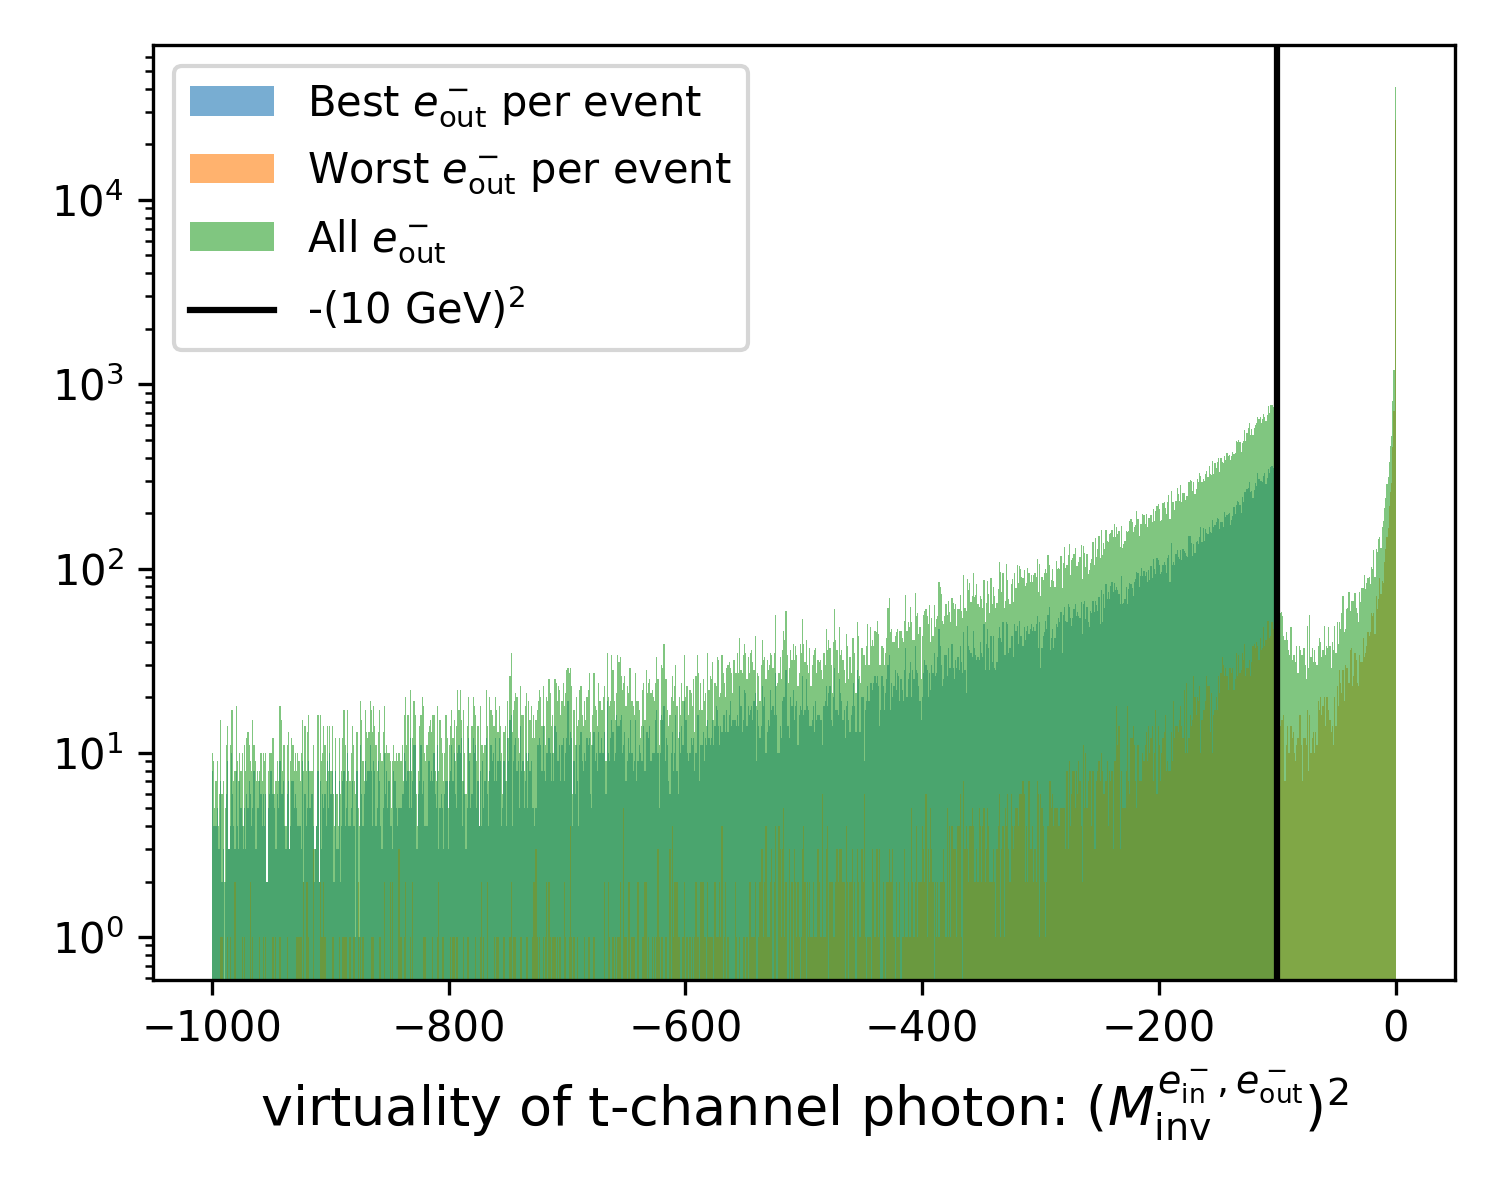

In [3]:
@load_or_make(["t_channel_virtuality_all.png"])
def t_channel_virtuality_all():
    fig, ax = plt.subplots(figsize=(5, 4))
    kw = dict(bins=np.linspace(-1000, 0, 1000), alpha=0.6)
    ax.hist(
        ak.min(m_inv_in_out_squared, axis=1),
        label=r"Best $e^-_\mathrm{out}}$ per event",
        **kw,
    )
    ax.hist(
        ak.max(m_inv_in_out_squared, axis=1),
        label=r"Worst $e^-_\mathrm{out}}$ per event",
        **kw,
    )
    ax.hist(ak.flatten(m_inv_in_out_squared), label=r"All $e^-_\mathrm{out}}$", **kw)
    ax.set_xlabel(
        r"virtuality of t-channel photon: $(M_\mathrm{inv}^{e^-_\mathrm{in}, e^-_\mathrm{out}})^2$",
        fontsize=13,
    )
    ax.axvline(-100, color="black", label="-(10 GeV)$^2$")
    ax.set_yscale("log")
    ax.legend()
    fig.tight_layout()
    return (fig,)


fig = t_channel_virtuality_all()

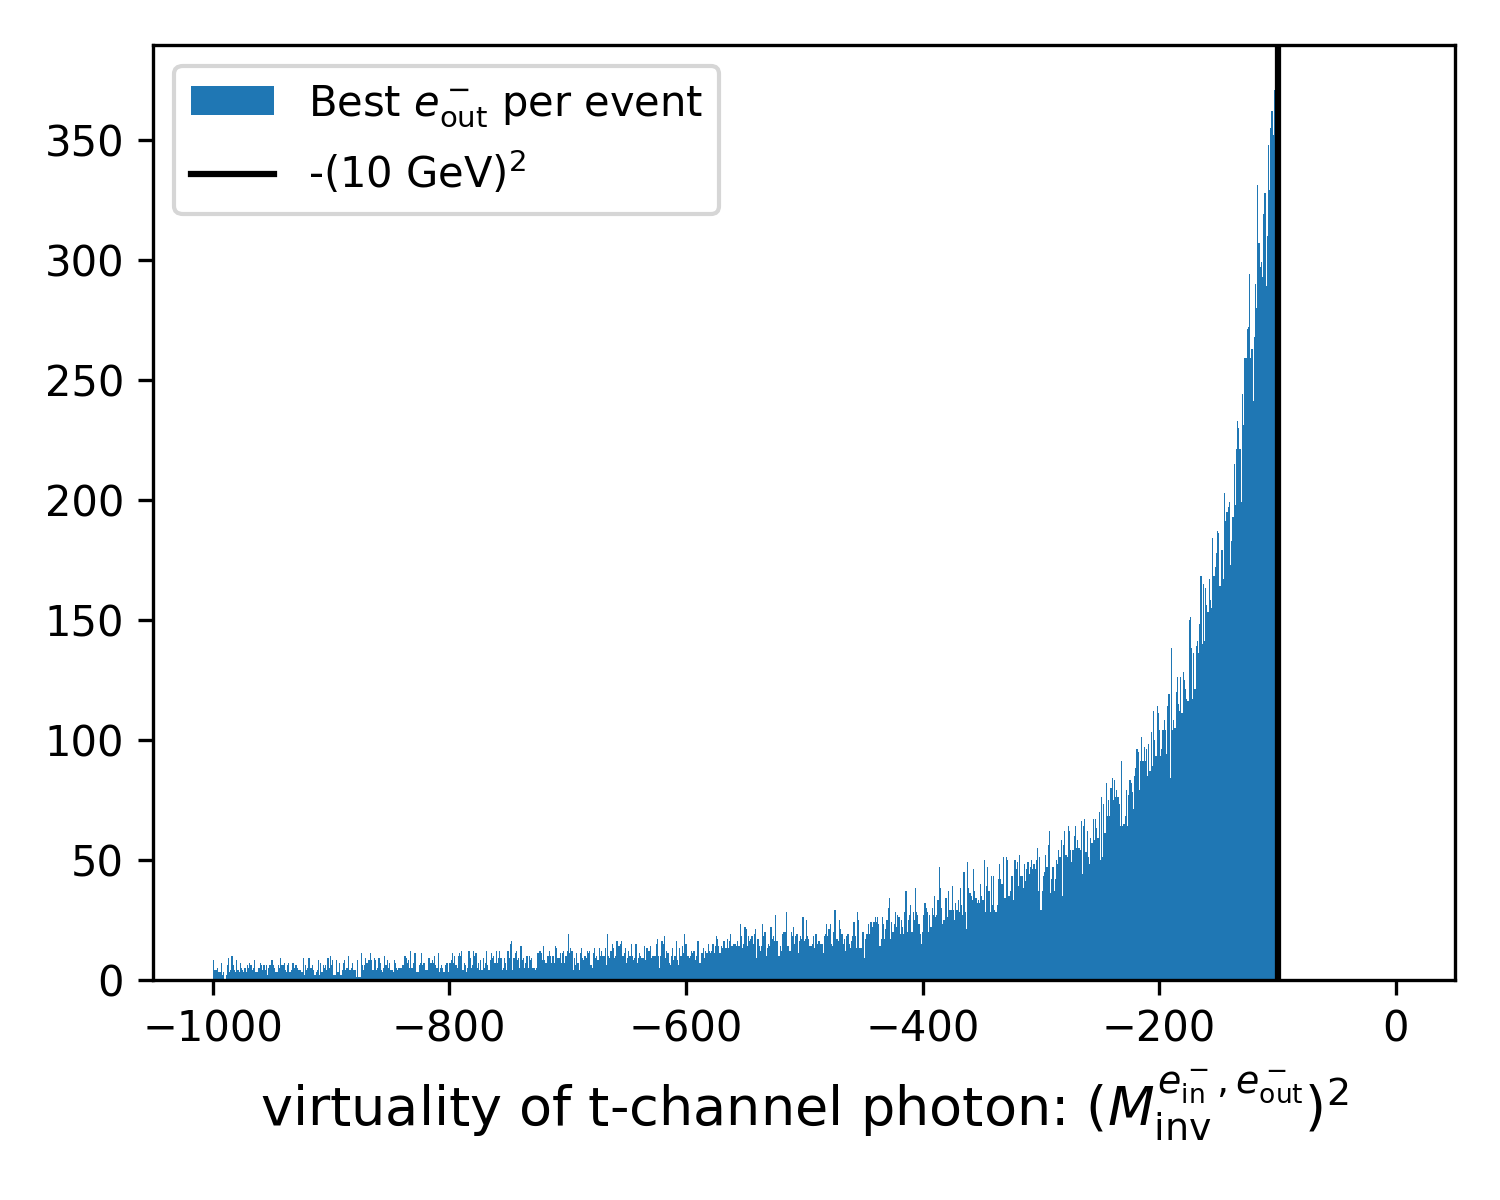

In [4]:
@load_or_make(["t_channel_virtuality.png"])
def t_channel_virtuality():
    fig, ax = plt.subplots(figsize=(5, 4))
    ax.hist(
        ak.min(m_inv_in_out_squared, axis=1),
        bins=np.linspace(-1000, 0, 1000),
        label=r"Best $e^-_\mathrm{out}}$ per event",
    )
    ax.set_xlabel(
        r"virtuality of t-channel photon: $(M_\mathrm{inv}^{e^-_\mathrm{in}, e^-_\mathrm{out}})^2$",
        fontsize=13,
    )
    ax.axvline(-100, color="black", label="-(10 GeV)$^2$")
    ax.legend()
    fig.tight_layout()
    return (fig,)


fig = t_channel_virtuality()

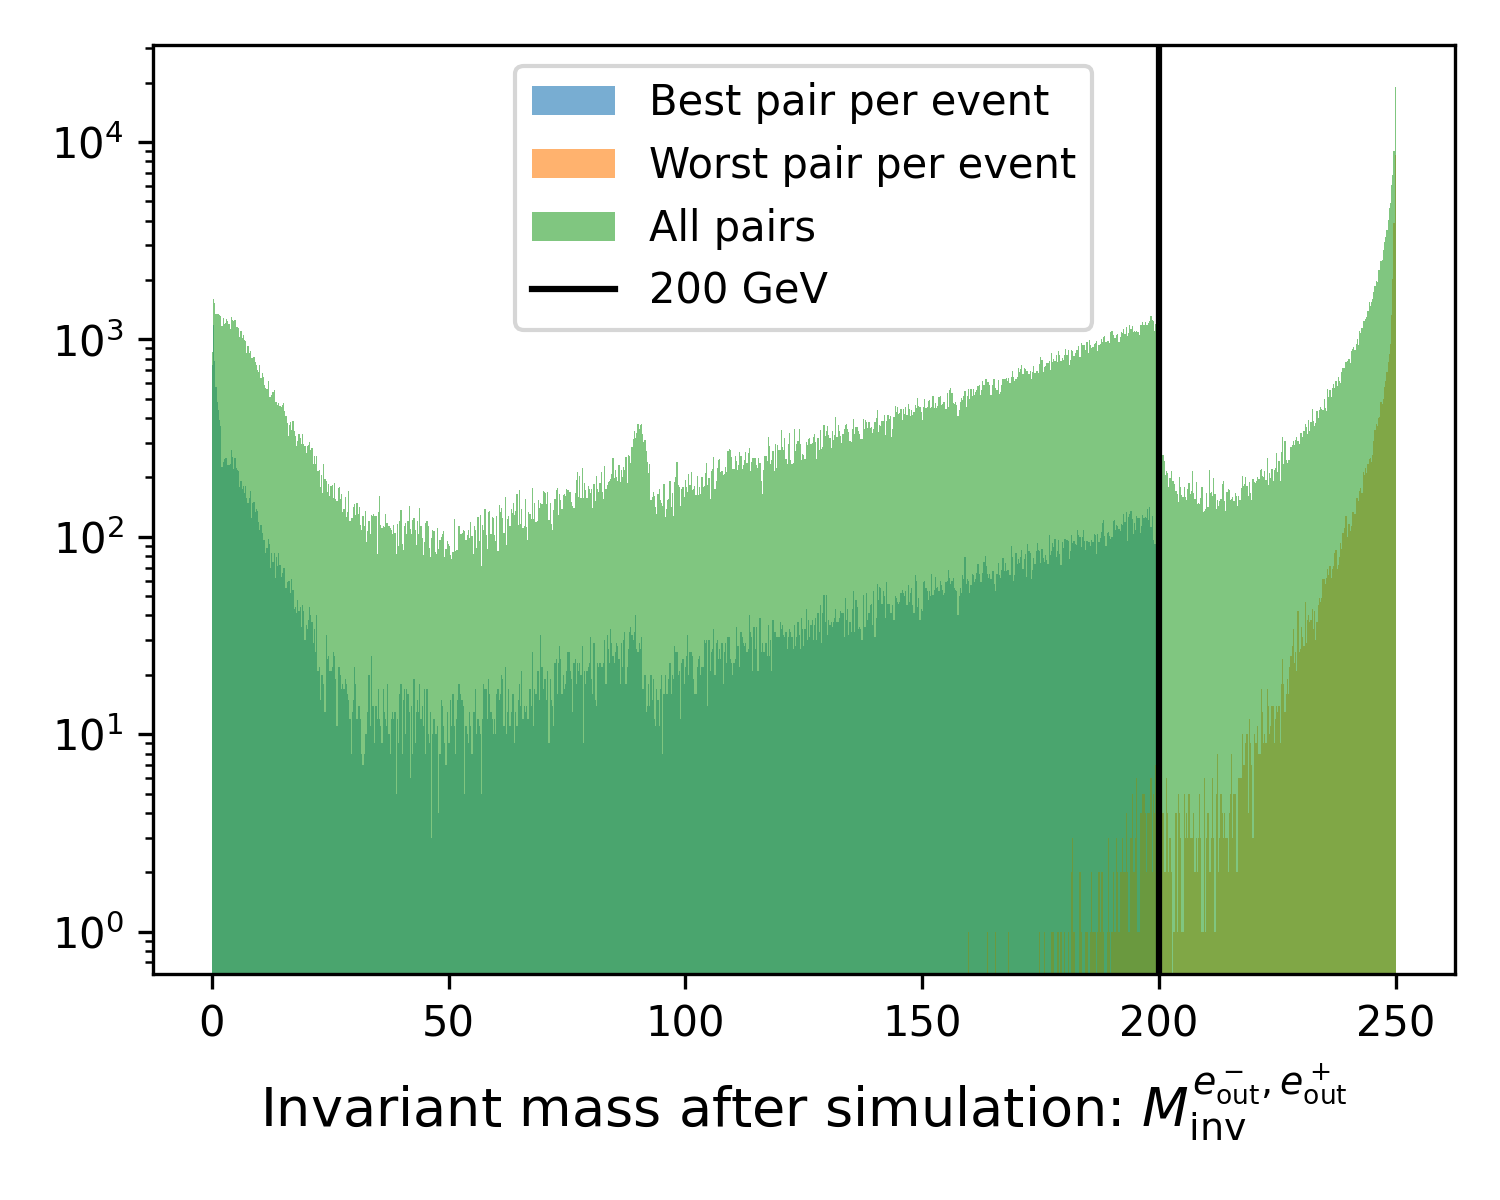

In [5]:
@load_or_make(["invariant_mass_simulation_all.png"])
def invariant_mass_simulation_all():
    fig, ax = plt.subplots(figsize=(5, 4))
    kw = dict(bins=np.linspace(0, 250, 1000), alpha=0.6)
    ax.hist(ak.min(m_inv_ep, axis=1), label="Best pair per event", **kw)
    ax.hist(ak.max(m_inv_ep, axis=1), label="Worst pair per event", **kw)
    ax.hist(ak.flatten(m_inv_ep), label="All pairs", **kw)
    ax.set_xlabel(
        r"Invariant mass after simulation: $M_\mathrm{inv}^{e^-_\mathrm{out}, e^+_\mathrm{out}}$",
        fontsize=13,
    )
    ax.axvline(200, color="black", label="200 GeV")
    ax.set_yscale("log")
    ax.legend()
    fig.tight_layout()
    return (fig,)


fig = invariant_mass_simulation_all()

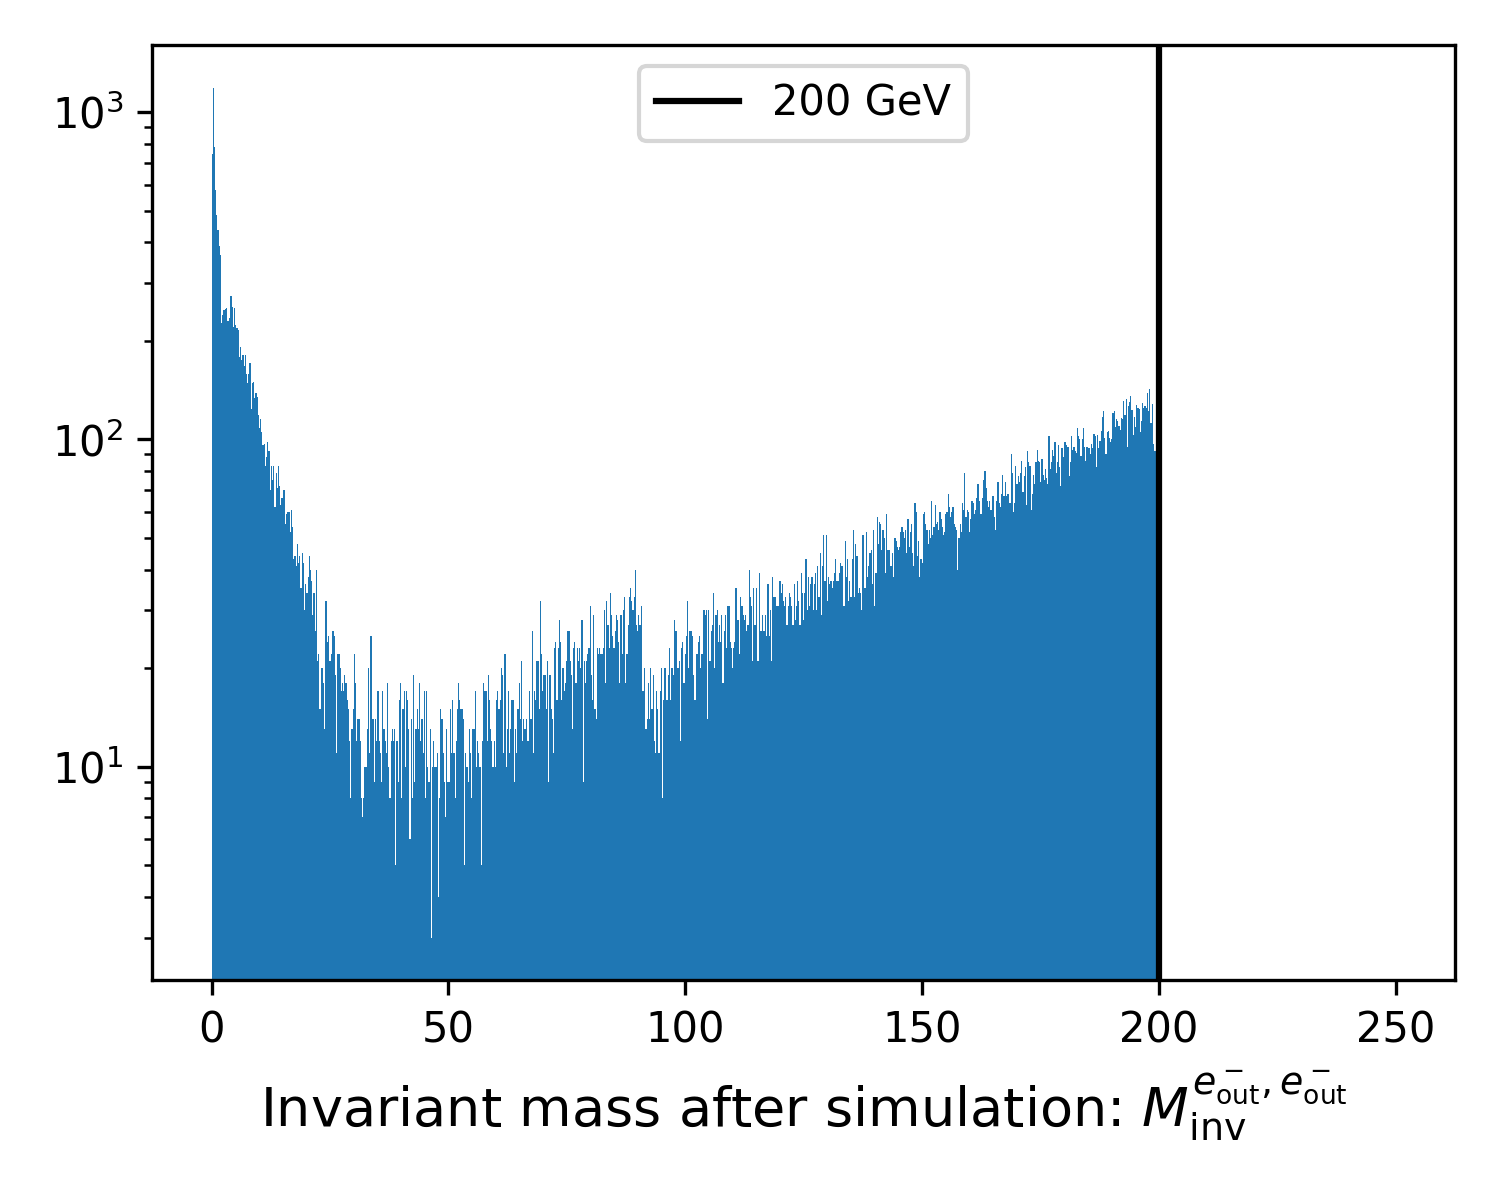

In [6]:
@load_or_make(["invariant_mass_simulation.png"])
def invariant_mass_simulation():
    fig, ax = plt.subplots(figsize=(5, 4))
    ax.hist(ak.min(m_inv_ep, axis=1), bins=np.linspace(0, 250, 1000))
    ax.set_xlabel(
        r"Invariant mass after simulation: $M_\mathrm{inv}^{e^-_\mathrm{out}, e^-_\mathrm{out}}$",
        fontsize=13,
    )
    ax.axvline(200, color="black", label="200 GeV")
    ax.set_yscale("log")
    ax.legend()
    fig.tight_layout()
    return (fig,)


fig = invariant_mass_simulation()

## Consequences of these cuts: cos𝜃 spectrum

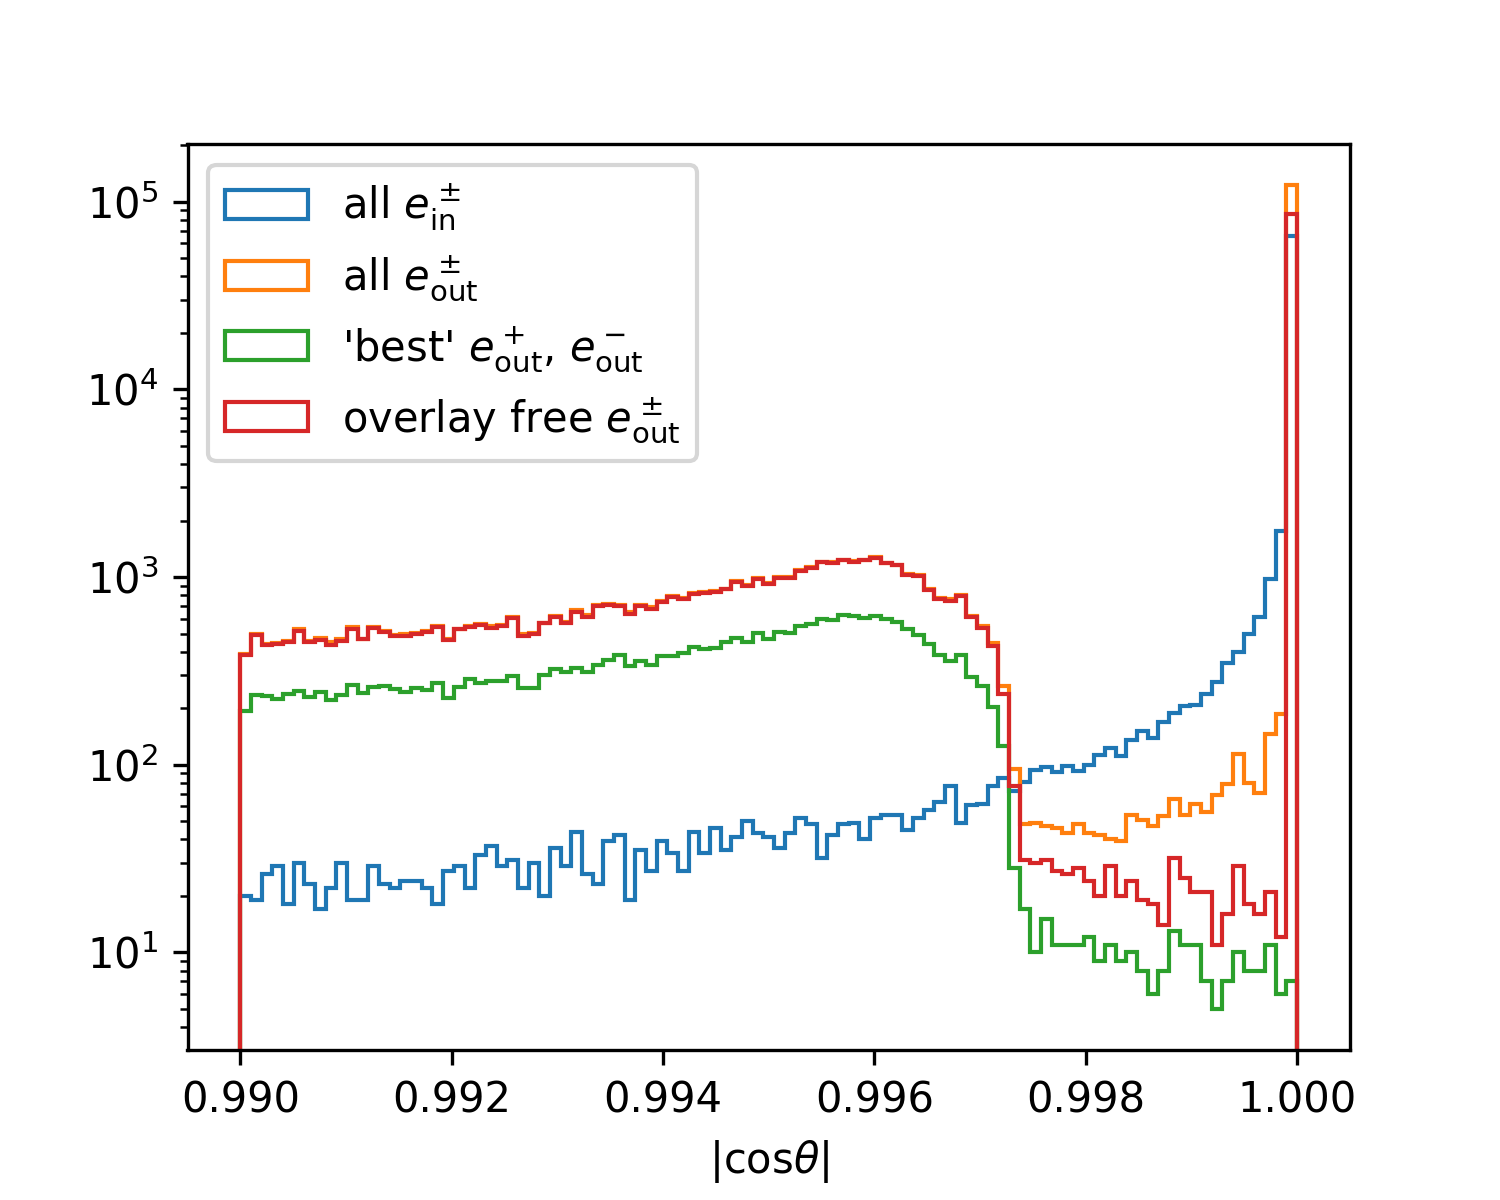

In [7]:
@load_or_make(["cos_theta_spectrum_simulation.png"])
def cos_theta_spectrum_simulation():
    kw = dict(bins=np.linspace(0.99, 1, 100), histtype="step")
    fig, ax = plt.subplots(figsize=(5, 4))
    for p1, p2, label, reducer in [
        (el_in, po_in, r"all $e^\pm_\mathrm{in}$", lambda x: ak.flatten(x)),
        (el_out, po_out, r"all $e^\pm_\mathrm{out}$", lambda x: ak.flatten(x)),
        (
            el_out,
            po_out,
            r"'best' $e^+_\mathrm{out}$, $e^-_\mathrm{out}$",
            lambda x: ak.min(x, axis=1),
        ),
        (
            el_out[~el_out.isOverlay],
            po_out[~po_out.isOverlay],
            r"overlay free $e^\pm_\mathrm{out}$",
            lambda x: ak.flatten(x),
        ),
    ]:
        x = np.concatenate(
            [reducer(np.abs(p1.mcmoz) / p1.mcene), reducer(np.abs(p2.mcmoz) / p2.mcene)]
        )
        ax.hist(x, label=label, **kw)
    ax.legend(loc="upper left")
    ax.set_yscale("log")
    ax.set_xlabel("|cos$\\theta$|")
    return (fig,)


fig = cos_theta_spectrum_simulation()